In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.functional import F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from ucimlrepo import fetch_ucirepo

In [2]:
# fetch dataset
breast_cancer = fetch_ucirepo(id=17)
x = breast_cancer.data.features
y = breast_cancer.data.targets

In [3]:
X = torch.tensor(x.values, dtype=torch.float32, device=device)
Y = torch.tensor([[1.] if i == 'M' else [0.] for i in y.values], dtype=torch.float32, device=device)
test_split = 500
X_train = X[:test_split]
X_test = X[test_split:]
Y_train = Y[:test_split]
Y_test = Y[test_split:]

In [4]:
class SimpleReLUNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.network = nn.Sequential(
            nn.Linear(30, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits


class ReLUNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.network = nn.Sequential(
            nn.Linear(30, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits


class LeakyReLUNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.network = nn.Sequential(
            nn.Linear(30, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(128, 64),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits


class DeepLeakyReLUNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.network = nn.Sequential(
            nn.Linear(30, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(128, 256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(256, 256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(256, 256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(256, 256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(256, 256),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(256, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(128, 64),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits


class GELUNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.network = nn.Sequential(
            nn.Linear(30, 128),
            nn.GELU(),
            nn.Dropout(p=0.25),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Dropout(p=0.25),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits


class SigmoidNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.network = nn.Sequential(
            nn.Linear(30, 128),
            nn.Sigmoid(),
            nn.Dropout(p=0.25),
            nn.Linear(128, 64),
            nn.Sigmoid(),
            nn.Dropout(p=0.25),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.network(x)
        return logits

In [5]:
# replace this line with a model to evaluate
model = SimpleReLUNeuralNetwork().to(device)
print(model)

# hyperparameters
learning_rate = 2.5e-4
n_epochs = 4000

loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

SimpleReLUNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [6]:
train_loss_tracker = []
test_accuracy_tracker = []
true_positives_tracker = []
true_negatives_tracker = []
false_positives_tracker = []
false_negatives_tracker = []
epochs = []

model.train()
for i in range(1, n_epochs + 1):
    optimizer.zero_grad()

    output = model(X_train)
    loss = loss_fn(output, Y_train)

    loss.backward()
    optimizer.step()
    
    if i % 20 == 0:
        epochs.append(i)
        train_loss_tracker.append(loss.item())
        model.eval()
        with torch.no_grad():
            predictions = [1. if x > .5 else 0. for x in model(X_test)]
            # correct_predictions = [(1 if x == y else 0) for x, y in zip(predictions, Y_test)]
            true_positives  = [(1 if x == 1 and y == 1 else 0) for x, y in zip(predictions, Y_test)]
            true_negatives  = [(1 if x == 0 and y == 0 else 0) for x, y in zip(predictions, Y_test)]
            false_positives = [(1 if x == 1 and y == 0 else 0) for x, y in zip(predictions, Y_test)]
            false_negatives = [(1 if x == 0 and y == 1 else 0) for x, y in zip(predictions, Y_test)]

            true_positives_tracker.append(sum(true_positives) / (sum(true_positives) + sum(false_negatives)))
            true_negatives_tracker.append(sum(true_negatives) / (sum(false_positives) + sum(true_negatives)))
            false_positives_tracker.append(sum(false_positives) / (sum(false_positives) + sum(true_negatives)))
            false_negatives_tracker.append(sum(false_negatives) / (sum(true_positives) + sum(false_negatives)))
            test_accuracy_tracker.append(
                (sum(true_positives) + sum(true_negatives)) /
                (sum(true_positives) + sum(true_negatives) + sum(false_positives) + sum(false_negatives))
            )

            if i % 100 == 0:
                print('Epoch:', i, 'Loss:', loss.item(), 'Test Accuracy:', test_accuracy_tracker[-1])
        model.train()

Epoch: 100 Loss: 13.209705352783203 Test Accuracy: 0.7971014492753623
Epoch: 200 Loss: 6.7760725021362305 Test Accuracy: 0.8985507246376812
Epoch: 300 Loss: 1.819593071937561 Test Accuracy: 0.8840579710144928
Epoch: 400 Loss: 1.114306926727295 Test Accuracy: 0.8840579710144928
Epoch: 500 Loss: 0.4959152936935425 Test Accuracy: 0.9130434782608695
Epoch: 600 Loss: 0.2923254668712616 Test Accuracy: 0.9130434782608695
Epoch: 700 Loss: 0.2580042779445648 Test Accuracy: 0.8985507246376812
Epoch: 800 Loss: 0.2330513298511505 Test Accuracy: 0.927536231884058
Epoch: 900 Loss: 0.2008167952299118 Test Accuracy: 0.927536231884058
Epoch: 1000 Loss: 0.20091985166072845 Test Accuracy: 0.927536231884058
Epoch: 1100 Loss: 0.20735673606395721 Test Accuracy: 0.9130434782608695
Epoch: 1200 Loss: 0.19344468414783478 Test Accuracy: 0.927536231884058
Epoch: 1300 Loss: 0.195132777094841 Test Accuracy: 0.927536231884058
Epoch: 1400 Loss: 0.19415368139743805 Test Accuracy: 0.927536231884058
Epoch: 1500 Loss: 0.

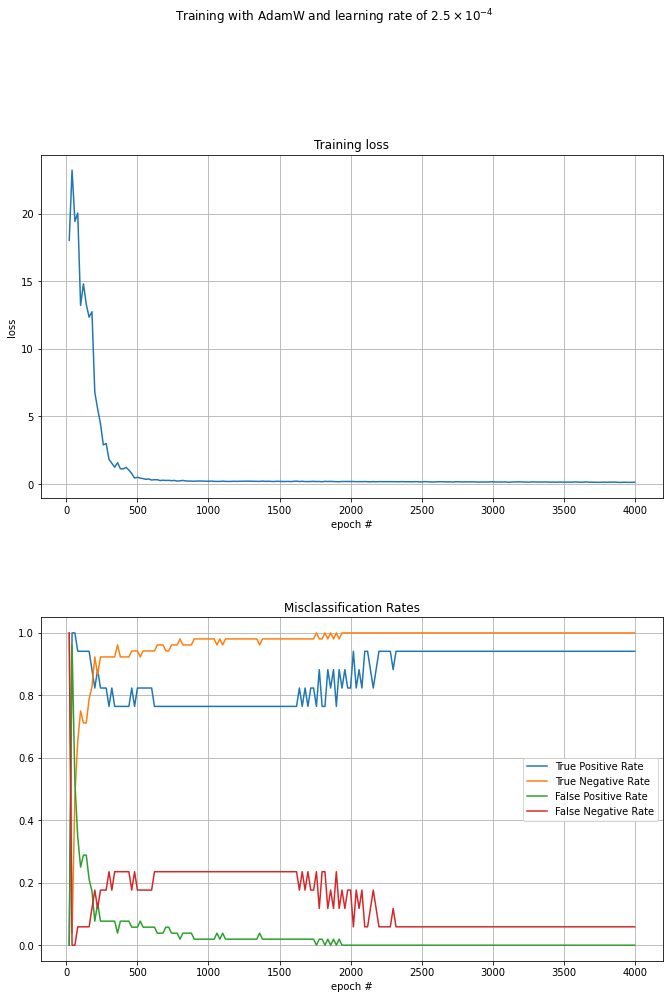

In [7]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Training with AdamW and learning rate of $2.5 \\times 10^{-4}$')
fig.tight_layout()
ax1.plot(epochs, train_loss_tracker)
ax1.set_title('Training loss')
ax1.set(xlabel='epoch #', ylabel='loss')
ax1.grid()
ax2.plot(epochs,  true_positives_tracker, label='True Positive Rate')
ax2.plot(epochs,  true_negatives_tracker, label='True Negative Rate')
ax2.plot(epochs,  false_positives_tracker, label='False Positive Rate')
ax2.plot(epochs,  false_negatives_tracker, label='False Negative Rate')
ax2.legend()
ax2.set_title('Misclassification Rates')
ax2.set(xlabel='epoch #')
ax2.grid()
fig.set_size_inches(10, 15)
fig.savefig('result.png', dpi=200, transparent=False)

In [8]:
false_negatives_tracker[-1]

0.058823529411764705

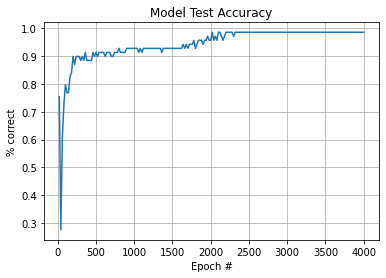

In [9]:
plt.plot(epochs, test_accuracy_tracker)
plt.grid()
plt.title('Model Test Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('% correct')
plt.show()

In [10]:
max(test_accuracy_tracker)

0.9855072463768116